# Filter Methods

In [1]:
from typing import Sequence, Union, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For auto-formatting of code
%load_ext lab_black

## Constant Features

* These are features that have just one unique value/label for all the observations of the dataset. 
* These features provide no valuable information. i.e they have no predictive power.
* Constant feature identification and removal is a simple first step toward feature selection and more easily interpretable machine learning models.

<br>

* **Numeric:** The variance can bu used to detect constant features. A constant feature has **zero** variance.
* **Categorical:** The unique labels can be used to detect constant features. If the number of unique labels is **zero**, then it's a unique constant.

In [2]:
lst = ["A", "A", "A", "A", "A", "A", "A", "A", "A", "A"]
size = 100

data = {
    "a1": lst * size,
    "a2": np.zeros(shape=(size * 10)),
    "a3": np.random.randint(1, 10, size=size * 10),
}

df = pd.DataFrame(data)
df.iloc[[7, 28, 85], 0] = ["B", "B", "B"]
df.head()

,a1,a2,a3
0,A,0.0,8
1,A,0.0,7
2,A,0.0,9
3,A,0.0,5
4,A,0.0,2


In [3]:
constant_vars = [feat for feat in df.columns if df[feat].nunique() == 1]

constant_vars

['a2']

## Quasi-constant

* Quasi-constant features are those that have the same value for the vast majority of the observations in the dataset. 
* In general, these characteristics provide little, if any, information that a machine learning model can use to predict a target.

```text
e.g. A feaure that has 99% of a particular label.
```

In [4]:
def check_constant_variables(*, data: pd.DataFrame, thresh: float = 0.98) -> dict:
    """This is used to detect the presence of constant/quasi-constant variables."""
    quasi_constant_vars = {}

    for feat in data.columns:
        feats_dict = data[feat].value_counts(normalize=True).to_dict()
        for key, val in feats_dict.items():
            if val >= thresh:
                quasi_constant_vars[f"{feat}({key})"] = val
    return quasi_constant_vars

In [5]:
result = check_constant_variables(data=df, thresh=0.98)
result

{'a1(A)': 0.997, 'a2(0.0)': 1.0}

### Using Feature-Engine

```python
from feature_engine.selection import DropConstantFeatures
sel = DropConstantFeatures(tol=1, variables=None, missing_values='raise')

sel.fit(X)
```

In [6]:
from feature_engine.selection import DropConstantFeatures

# Drop Constant Features
feat_selector = DropConstantFeatures(tol=1, variables=None, missing_values="raise")

feat_selector.fit(df)

DropConstantFeatures()

In [7]:
dir(feat_selector)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_new_feature_names',
 '_check_feature_names',
 '_check_n_features',
 '_check_variable_number',
 '_confirm_variables',
 '_confirm_variables_docstring',
 '_get_feature_names_in',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_remove_feature_names',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_sklearn_auto_wrap_output_keys',
 '_validate_data',
 '_validate_params',
 'confirm_variables',
 'feature_names_in_',
 'features_to_drop_',
 'fit',
 'fit_transform',
 'get_feature_names_out',
 'get_params',
 'get_support',
 'missing_values',
 'n_features_in_',
 'set_output',
 

In [8]:
feats_to_drop = feat_selector.features_to_drop_
print(f"Dropped features: {feats_to_drop}\n")

Dropped features: ['a2']



In [9]:
df_transformed = feat_selector.transform(df)
df_transformed.head()

,a1,a3
0,A,8
1,A,7
2,A,9
3,A,5
4,A,2


In [10]:
from feature_engine.selection import DropConstantFeatures

# Drop Quasi-Constant Features
THRESH = 0.98
feat_selector = DropConstantFeatures(tol=THRESH, variables=None, missing_values="raise")

df_transformed = feat_selector.fit_transform(df)

feats_to_drop = feat_selector.features_to_drop_
print(f"Dropped features: {feats_to_drop}\n")

df_transformed.head()

Dropped features: ['a1', 'a2']



,a3
0,8
1,7
2,9
3,5
4,2


## Dropping Correlated Features

* Correlation Feature Selection evaluates feature subsets based on the following hypothesis: 
  * Good feature subsets contain features that are highly correlated with the target but are uncorrelated with one another.

There are 2  approaches used in theis notebook:
1. The first is a brute force function that finds correlated features without any additional information.
2. The second procedure identifies groups of correlated features, which we can then investigate to determine which ones to keep and which to discard.

In [11]:
from feature_engine.selection import DropCorrelatedFeatures, SmartCorrelatedSelection
from sklearn.model_selection import train_test_split

In [12]:
def load_data(*, filename: str, sep: str = ",") -> pd.DataFrame:
    """This is used to load the data.

    Params;
        filename (str): The filepath.
        sep (str, default=","): The separator. e.g ',', '\t', etc

    Returns:
        data (pd.DataFrame): The loaded dataframe.
    """
    data = pd.read_csv(filename, sep=sep)
    print(f"Shape of data: {data.shape}\n")
    return data


def evaluate_model(*, y_true: np.ndarray, y_pred: np.ndarray) -> str:
    """This is used to evaluate a regressor."""
    from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

    # Mean Squared Error (The lower, the better)
    mse = mean_squared_error(y_true=y_true, y_pred=y_pred, squared=True)

    # Root Mean Squared Error (The lower, the better)
    # Remember to use squared=False
    rmse = mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False)

    # Mean Absolute Error (The lower, the better)
    mae = mean_absolute_error(y_true=y_true, y_pred=y_pred)

    # R Squared (The higher, the better. Max (best) value is 1)
    R2 = r2_score(y_true=y_true, y_pred=y_pred)
    lower, higher = "Lower is better!", "Higher is better!"

    result_str = (
        "================ Evaluation Metrics ================"
        f"\nMean Squared Error ({lower}!): {round(mse, 3)}"
        f"\nRoot Mean Squared Error ({lower}!): {round(rmse, 3)}"
        f"\nMean Absolute Error ({lower}!): {round(mae, 3)}"
        "\n==================================================="
        f"\nR Squared ({higher}!): {round(R2, 3)} "
    )

    return result_str

In [13]:
# Load data
data = load_data(filename="../../data/student-por.csv", sep=";")

data.head()

Shape of data: (649, 33)



,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [14]:
# Split into train and validation
RANDOM_STATE = 123
TEST_SIZE = 0.2
TARGET = "G3"

X = data.drop(columns=[TARGET])
y = data.get(TARGET)

X_train, X_validation, y_train, y_validation = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

X_train.shape, X_validation.shape

((519, 32), (130, 32))

#### Drop Correlated Features (Brute Force)


In [15]:
feat_selector = DropCorrelatedFeatures(variables=None, method="pearson", threshold=0.8)
train_data_transformed = feat_selector.fit_transform(X_train)
validation_data_transformed = feat_selector.transform(X_validation)

feats_to_drop = feat_selector.features_to_drop_
print(f"Dropped features: {feats_to_drop}\n")

Dropped features: {'G2'}



In [16]:
train_data_transformed.head(2)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1
243,GP,F,17,U,GT3,A,2,1,other,other,...,yes,yes,3,2,3,1,2,3,0,15
234,GP,F,17,R,GT3,T,2,1,at_home,services,...,yes,no,4,2,5,1,2,5,0,11


#### Drop Correlated Groups

In [17]:
# Build a simple model for evaluation
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()

METHOD, THRESH = "pearson", 0.8
SELECTION_METHOD, SCORING = "model_performance", "r2"
CV = 3

feat_selector = SmartCorrelatedSelection(
    variables=None,
    method=METHOD,
    threshold=THRESH,
    selection_method=SELECTION_METHOD,
    scoring=SCORING,
    estimator=linear_model,
    cv=CV,
)
train_data_transformed = feat_selector.fit_transform(X_train, y_train)
validation_data_transformed = feat_selector.transform(X_validation)

feats_to_drop = feat_selector.features_to_drop_
print(f"Dropped features: {feats_to_drop}\n")

Dropped features: ['G1']



In [18]:
# Groups of correlated features
feat_selector.correlated_feature_sets_

[{'G1', 'G2'}]

In [19]:
train_data_transformed.head(2)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G2
243,GP,F,17,U,GT3,A,2,1,other,other,...,yes,yes,3,2,3,1,2,3,0,15
234,GP,F,17,R,GT3,T,2,1,at_home,services,...,yes,no,4,2,5,1,2,5,0,10


### Univariate Feature Selection

#### Mutual information

> In probability theory and information theory, the mutual information (MI) of two random variables is a measure of the mutual dependence between the two variables. More specifically, it quantifies the "amount of information" (in units such as shannons (bits), nats or hartleys) obtained about one random variable by observing the other random variable. It is equal to **zero** if and only if two random variables are independent, and **higher values** mean **higher dependency**.

* This can be done bu using sklearn's implementation of `Mutual Information`
* Regression: Using `sklearn.feature_selection.mutual_info_regression`
* Classification: Using `sklearn.feature_selection.mutual_info_classif`

* Examples can be found **[here](https://github.com/chineidu/feature-selection-for-machine-learning/blob/main/05-Filter-Statistical-Tests/05.1-Mutual-information.ipynb)**

<hr>

#### Chi-Square Test for Feature Selection

* In statistics, the chi-square test is used to determine the independence of two events. We can get observed count `Obs` and expected count `Exp` from the data of two variables. Chi-Square measures how expected count `Exp` and observed count `Obs` deviates each other. **[source](https://towardsdatascience.com/chi-square-test-for-feature-selection-in-machine-learning-206b1f0b8223)**

$$chi_{squared} = \sum{\frac{(Obs - Exp)^2}{Exp}} $$

* An example can be found **[here](https://github.com/chineidu/feature-selection-for-machine-learning/blob/main/05-Filter-Statistical-Tests/05.2-Chi-square-test.ipynb)**

<hr>

#### Univariate Feature Selection Using ANOVA

* The best features are chosen using univariate statistical tests in univariate feature selection (ANOVA). The degree of linear dependency between two random variables (the predictor variable and the target) is estimated using this method.

* **ANOVA** assumes that the feature and the target have a linear relationship and that the variables have a Gaussian distribution. If this is not the case, the outcome of this test may be ineffective.

* An example showing the implementation can be found **[here](https://github.com/chineidu/feature-selection-for-machine-learning/blob/main/05-Filter-Statistical-Tests/05.3-Univariate-selection.ipynb)**.

<br><hr>

### Univariate roc-auc or mse 

* You can use any other evaluation metrics.
* Steps:

1. Build an ML model using a single feature to predict the target.
2. Make predictions and evaluate model predictions using any suitable metric.
   * Regression: MSE, RMSE, MAE, R2
   * Classification: ROC_AUC, Accuracy, Recall, etc
3. Rank the features using the metrics.
4. Select the highest ranking features.

In [20]:
from pydantic import BaseModel


class Data(BaseModel):
    """This class represents the schema of a data object."""

    X_train: Union[pd.DataFrame, np.ndarray]
    X_validation: Union[pd.DataFrame, np.ndarray]
    y_train: Union[pd.Series, np.ndarray, Sequence]
    y_validation: Union[pd.Series, np.ndarray, Sequence]

    class Config:
        arbitrary_types_allowed = True


data_dict = {
    "X_train": X_train,
    "X_validation": X_validation,
    "y_train": y_train,
    "y_validation": y_validation,
}
sample_data = Data(**data_dict)

In [49]:
class BestFeatures:
    """This is used to calculate the best features by creating a simple
    estimator with a single feature and evaluating its performance with that feature."""

    MAE = "MAE"
    ROC_AUC = "ROC_AUC"
    REGRESSION = "regression"
    CLASSIFICATION = "classification"

    def __init__(
        self,
        *,
        data: pd.DataFrame,
        target: str,
        type_: str,
        random_state: int = 123,
    ) -> None:
        self.data = data
        self.target = target
        if type_ not in [self.REGRESSION, self.CLASSIFICATION]:
            raise Exception(
                f"{type_!r} must be {self.type_list[0]!r} or {self.type_list[1]!r}"
            )
        self.type_ = type_.lower().strip()
        self.random_state = random_state
        self.eval_metric = self.MAE if self.type_ == self.REGRESSION else self.ROC_AUC
        self.status = (
            "lower is better!" if self.type_ == self.REGRESSION else "higher is better!"
        )
        self.order = False if self.type_ == self.REGRESSION else True
        self.feature_rankings = {}

    def __repr__(self) -> str:
        return (
            f"{self.__class__.__name__}(Data_shape=({self.data.shape}), "
            f"target=({self.target!r}), type_={self.type_!r}, "
            f"random_state=({self.random_state}), eval_metric={self.eval_metric!r})"
        )

    def select_best_features(self) -> dict[str]:
        """Determine the best features."""
        from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
        from sklearn import metrics

        message = {
            "type": self.type_,
            "evaluation metric": self.eval_metric,
            "status": self.status,
        }

        print(message)

        for feat in self.data.columns:
            if feat != self.target:
                X = self.data[[feat, self.target]]
                # Split the data
                X_train, X_validation, y_train, y_validation = self._split_data(
                    data=X,
                    target=self.target,
                    random_state=self.random_state,
                    display_shape=False,
                )
                if self.type_ == self.REGRESSION:  # regression
                    estimator = RandomForestRegressor(random_state=self.random_state)
                    # Fit model
                    estimator.fit(X_train, y_train)
                    # Make predictions
                    y_pred = estimator.predict(X_validation)
                    # Evaluate estimator
                    mae = metrics.mean_absolute_error(
                        y_true=y_validation, y_pred=y_pred
                    )
                    self.feature_rankings[feat] = mae
                else:  # classification
                    estimator = RandomForestClassifier(random_state=self.random_state)
                    # Fit model
                    estimator.fit(X_train, y_train)
                    y_pred = estimator.predict_proba(X_validation)[:, 1]
                    mae = metrics.roc_auc_score(y_true=y_validation, y_score=y_pred)
                    self.feature_rankings[feat] = mae
        # Sort the dict
        if self.type_ == self.REGRESSION:
            self.feature_rankings = self._sort_dict(
                input_dict=self.feature_rankings, ascending=self.order
            )
        else:
            self.feature_rankings = self._sort_dict(
                input_dict=self.feature_rankings, ascending=self.order
            )
        return self.feature_rankings

    def visualize_rankings(self) -> "Plot":
        """This returns a bar plot showing the features and the metric used."""
        # Determine best features and create DataFrame
        self.select_best_features()
        df = pd.DataFrame(self.feature_rankings, index=[0]).T
        eval_metric = self.MAE if self.type_ == self.REGRESSION else self.ROC_AUC

        df = df.rename(columns={0: eval_metric}).sort_values(
            by=eval_metric, ascending=self.order
        )

        THRESH = (
            np.percentile(df[eval_metric], q=40)
            if self.type_ == self.REGRESSION
            else np.median(df[eval_metric])
        )
        print(f"Threshold: {THRESH}")

        df.plot(
            kind="bar",
            title=f"{eval_metric!r} of The Features ({self.status})",
            xlabel=eval_metric,
            figsize=(8, 5),
        )
        plt.axhline(y=THRESH, color="red")
        plt.tight_layout()

    plt.show()

    @staticmethod
    def _split_data(
        *,
        data: pd.DataFrame,
        target: str,
        random_state: int = 123,
        test_size: float = 0.2,
        display_shape: bool = True,
    ) -> tuple[np.ndarray]:
        """This split the data into X_train, X_validation, y_train, y_validation."""
        # Split into train and validation

        X = data.drop(columns=[target])
        y = data.get(target)

        X_train, X_validation, y_train, y_validation = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )
        if display_shape:
            print(
                f"Shape of X_train: {X_train.shape}, \nShape of X_validation: {X_validation.shape}"
            )
        return (X_train, X_validation, y_train, y_validation)

    @staticmethod
    def _sort_dict(*, input_dict: dict, ascending: bool = True) -> dict:
        """This is used to sort a dict using the values."""
        sorted_dict = dict(
            sorted(input_dict.items(), key=lambda x: x[1], reverse=ascending)
        )
        return sorted_dict

#### Regression

In [50]:
from feature_engine.encoding import OrdinalEncoder

X = data.drop(columns=["G3"])
y = data["G3"]

ordinal_enc = OrdinalEncoder(encoding_method="ordered")
df = ordinal_enc.fit_transform(X=X, y=y)
df = pd.concat([df, y], axis=1)
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,1,1,18,1,0,1,4,4,0,4,...,4,3,4,1,1,3,4,0,11,11
1,1,1,17,1,0,0,1,1,0,2,...,5,3,3,1,1,3,2,9,11,11
2,1,1,15,1,1,0,1,1,0,2,...,4,3,2,2,3,3,6,12,13,12
3,1,1,15,1,0,0,4,2,3,1,...,3,2,2,1,1,5,0,14,14,14
4,1,1,16,1,0,0,3,3,1,2,...,4,3,2,1,2,5,0,11,13,13


In [51]:
best_feats = BestFeatures(data=df, target="G3", type_="regression")
best_feats

BestFeatures(Data_shape=((649, 33)), target=('G3'), type_='regression', random_state=(123), eval_metric='MAE')

In [52]:
feature_importance = best_feats.select_best_features()
feature_importance

{'type': 'regression', 'evaluation metric': 'MAE', 'status': 'lower is better!'}


{'G2': 0.7991711614563183,
 'G1': 1.1467172396004768,
 'failures': 2.319934085230682,
 'studytime': 2.379904793540111,
 'Mjob': 2.4008390500043357,
 'Medu': 2.407328668591459,
 'reason': 2.4272715526098216,
 'Fedu': 2.4296267540045235,
 'absences': 2.4486701495904395,
 'address': 2.4520608914265387,
 'internet': 2.471074291957501,
 'school': 2.499210973795942,
 'goout': 2.5021464634046744,
 'higher': 2.502745985421588,
 'freetime': 2.5054945431941147,
 'Fjob': 2.5124706091789912,
 'age': 2.515198602558132,
 'famrel': 2.524446779174147,
 'guardian': 2.5301951778957372,
 'traveltime': 2.5353308187778065,
 'schoolsup': 2.5371846976973242,
 'activities': 2.5409789413691124,
 'Walc': 2.5453486482019074,
 'health': 2.547657835448039,
 'romantic': 2.5514603085151424,
 'nursery': 2.5522863580658663,
 'famsize': 2.5569831398905762,
 'Pstatus': 2.5577231693285114,
 'paid': 2.5657052172293096,
 'sex': 2.5732817728555055,
 'Dalc': 2.5733309620758145,
 'famsup': 2.652336119898362}

{'type': 'regression', 'evaluation metric': 'MAE', 'status': 'lower is better!'}
Threshold: 2.5023862722114396


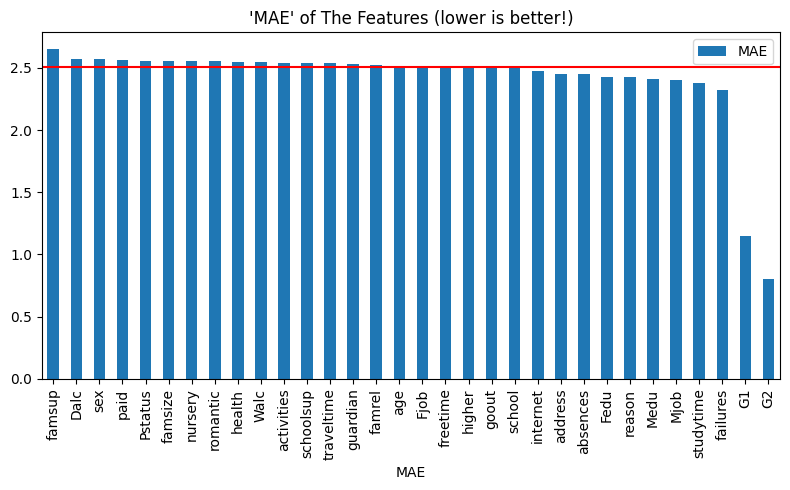

In [53]:
best_feats.visualize_rankings()

In [54]:
import itertools

# Best N features
N = 26
best_feats = dict(itertools.islice(feature_importance.items(), 0, N))
best_feats = list(best_feats.keys())
print(best_feats)

['G2', 'G1', 'failures', 'studytime', 'Mjob', 'Medu', 'reason', 'Fedu', 'absences', 'address', 'internet', 'school', 'goout', 'higher', 'freetime', 'Fjob', 'age', 'famrel', 'guardian', 'traveltime', 'schoolsup', 'activities', 'Walc', 'health', 'romantic', 'nursery']


In [55]:
from sklearn.ensemble import RandomForestRegressor


dff = data[best_feats + ["G3"]]
dff = pd.get_dummies(dff)
split = BestFeatures(data=dff, target="G3", type_="regression")
X_train, X_validation, y_train, y_validation = split._split_data(data=dff, target="G3")

reg = RandomForestRegressor(random_state=RANDOM_STATE)

# Fit
reg.fit(X_train, y_train)

# Make predictions
y_pred = reg.predict(X_validation)

# Evaluate
print(evaluate_model(y_true=y_validation, y_pred=y_pred))

Shape of X_train: (519, 47), 
Shape of X_validation: (130, 47)
================ Evaluation Metrics ================
Mean Squared Error (Lower is better!!): 1.611
Root Mean Squared Error (Lower is better!!): 1.269
Mean Absolute Error (Lower is better!!): 0.826
R Squared (Higher is better!!): 0.851 


#### Classification

In [56]:
dff = load_data(filename="../../data/titanic_train.csv")
features = ["Sex", "Age", "Pclass", "SibSp", "Parch", "Fare", "Embarked", "Survived"]
dff = dff[features].dropna()

dff.head()

Shape of data: (891, 12)



,Sex,Age,Pclass,SibSp,Parch,Fare,Embarked,Survived
0,male,22.0,3,1,0,7.2500,S,0
1,female,38.0,1,1,0,71.2833,C,1
2,female,26.0,3,0,0,7.9250,S,1
3,female,35.0,1,1,0,53.1000,S,1
4,male,35.0,3,0,0,8.0500,S,0


In [57]:
from feature_engine.encoding import MeanEncoder

X = dff.drop(columns=["Survived"])
y = dff["Survived"]
mean_enc = MeanEncoder(variables=["Sex", "Embarked"])
df = mean_enc.fit_transform(X=X, y=y)
df = pd.concat([df, y], axis=1)

df.head()

,Sex,Age,Pclass,SibSp,Parch,Fare,Embarked,Survived
0,0.205298,22.0,3,1,0,7.2500,0.362816,0
1,0.752896,38.0,1,1,0,71.2833,0.607692,1
2,0.752896,26.0,3,0,0,7.9250,0.362816,1
3,0.752896,35.0,1,1,0,53.1000,0.362816,1
4,0.205298,35.0,3,0,0,8.0500,0.362816,0


In [58]:
best_feats = BestFeatures(data=df, target="Survived", type_="classification")
best_feats

BestFeatures(Data_shape=((712, 8)), target=('Survived'), type_='classification', random_state=(123), eval_metric='ROC_AUC')

In [59]:
best_feats.select_best_features()

{'type': 'classification', 'evaluation metric': 'ROC_AUC', 'status': 'higher is better!'}


{'Sex': 0.7239959839357429,
 'Pclass': 0.7147590361445783,
 'Fare': 0.6929718875502009,
 'Embarked': 0.6385542168674698,
 'Parch': 0.61285140562249,
 'SibSp': 0.5634538152610441,
 'Age': 0.5210843373493976}

{'type': 'classification', 'evaluation metric': 'ROC_AUC', 'status': 'higher is better!'}
Threshold: 0.6385542168674698


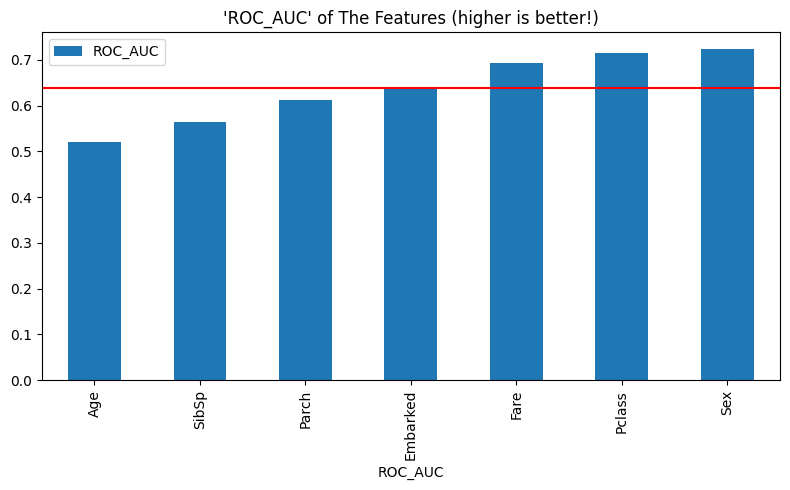

In [60]:
best_feats.visualize_rankings()